In [2287]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

# QRS Complex Dectition Algorithm


## 1.0 Acquiring the Data

In [2288]:
# Load the dataset with comma as delimiter
df = pd.read_csv("lab5_Philco-L05.txt", delimiter=",")

df = df[:40000]

df.head()

,sec,CH1,CH40,Unnamed: 3
0,0.000,-0.120850,0.0,NaN
1,0.001,-0.123596,0.0,NaN
2,0.002,-0.126343,0.0,NaN
3,0.003,-0.129395,0.0,NaN
4,0.004,-0.131836,0.0,NaN


## 2.0 Cleaning the Dataset

In [2289]:
# Removing unnecessary columns
df = df.drop('Unnamed: 3', axis=1) # Unnecessary
df = df.drop('CH40', axis=1)

df.head()

,sec,CH1
0,0.000,-0.120850
1,0.001,-0.123596
2,0.002,-0.126343
3,0.003,-0.129395
4,0.004,-0.131836


## 3.0 QRS Helper Functions

### 3.1 Rate of Change Function
This function gets the first and second derivative of the original given signal and adds their absolute components together, to take a look at the rate of change of the data. The QRS component of each beat can be identified by the largest peakls in the plot. 

The function steps:
--> Gets first derivative
--> Gets second derivative
--> Adds absolute values of first and second derivative
--> Transnforms to frequency domain
--> applies a low pass filter to the data
--> return to time domain
--> plots the rate of change
--> returns both x and y components of the rate of change plot

In [2290]:
def rate_of_change(signal_x, signal_y):

    # remove dc component
    signal_y = signal_y - np.sum(signal_y)/len(signal_y)

    # Compute the first derivative
    first_derivative = np.gradient(signal_y, signal_x)

    # Compute the second derivative
    second_derivative = np.gradient(first_derivative, signal_x)

    roc_data = abs(first_derivative) + abs(second_derivative)

    # Find the frequency domain components
    fft_result = np.fft.fft(roc_data)

    # Compute the frequencies corresponding to the FFT result
    n = len(roc_data)
    dt = np.diff(signal_x).mean()  # Calculate the mean time step
    freq = np.fft.fftfreq(n, d=dt)  # Compute the frequency array

    # Define the cutoff frequency for the low-pass filter
    cutoff_freq = 50

    # Create the low-pass filter
    lowpass_filter = np.zeros_like(freq)
    lowpass_filter[np.abs(freq) <= cutoff_freq] = 1

    # Apply the low-pass filter to the FFT result
    filtered_fft_result = fft_result * lowpass_filter

    # Compute the inverse FFT (return to time domain)
    ifft_result = np.fft.ifft(filtered_fft_result)

    return signal_x, np.real(ifft_result)

### 3.2 QRS Detection Function
This function initially checks for QRS complexes mathematically, this way, we can develop a target column from which to train the machine learning model.

The function:
--> Randomly chooses three 500 length windows to calculate the max values from these. 
--> Avarages the max values and uses this values as a threshold for QRS detection.
--> Returns a binary enconded array and the actual values when a QRS is detected.

In [2291]:
def qrs_detection(x_data, y_data):
  
    window_size = 500

    # Randomly select 4 starting indices for the windows
    start_indices = [random.randint(0, len(y_data) - window_size) for _ in range(4)]

    # Initialize lists to store the maximum and minimum values from each window
    max_values = []
    min_values = []

    # Iterate over the starting indices and find the maximum and minimum values in each window
    for start_index in start_indices:
        window_data = y_data[start_index:start_index + window_size]
        max_value_in_window = np.max(window_data)
        min_value_in_window = np.min(window_data)
        max_values.append(max_value_in_window)
        min_values.append(min_value_in_window)

    # Calculate the average of the maximum and minimum values
    avg_max_value = np.mean(max_values)
    avg_min_value = np.mean(min_values)

    # Calculate the threshold using the average values
    threshold = ((avg_max_value - avg_min_value) / 2)

    # Initialize a list to store the new y_data
    y_qrs_detected_binary = []
    x_qrs_detected = []
    y_qrs_detected = []

    # Iterate through data
    for x,y in zip(x_data,y_data):
        if y > threshold:
            y_qrs_detected_binary.append(1)
            y_qrs_detected.append(y)
            x_qrs_detected.append(x)
        else:
            y_qrs_detected_binary.append(0)

    # Plot the values
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, label='Original Signal', color='blue')
    plt.scatter(x_qrs_detected, y_qrs_detected, color='red', label='QRS Detected')
    plt.xlabel('Time')
    plt.ylabel('QRS Detection')
    plt.title('QRS Detection Result')
    plt.legend()
    plt.grid(True)
    plt.show()

    return x_data, y_qrs_detected_binary, y_qrs_detected


## 4.0 Get More Feature Columns from Dataset

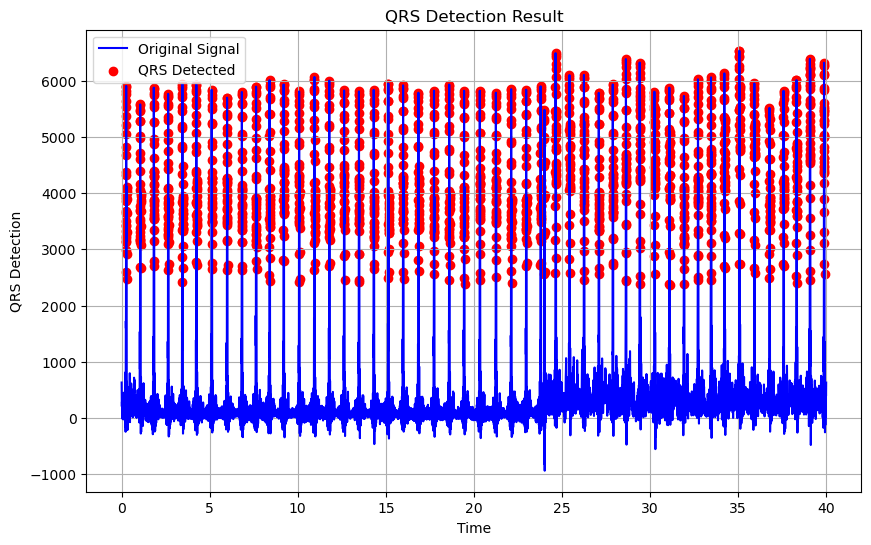

In [2292]:
# Get the time column
time = df.iloc[:, 0]

# Get the Channel data
data = df.iloc[:, 1]

# Find the rate of change of the values
[x_data, y_data] = rate_of_change(time, data)

# Create a DataFrame for the rate of change
rate_of_change_df = pd.DataFrame({'Rate_of_change': y_data})

# Concatenate the rate of change DataFrame with the original dataset
df = pd.concat([df, rate_of_change_df], axis=1)

# Find the QRS Complexes thorugh rate of change
[qrs_x, qrs_y_binary, qrs_y] = qrs_detection(x_data, y_data)

# QRS Binary data frame
qrs_df_binary = pd.DataFrame({'QRS_detected_binary': qrs_y_binary})

# Add them to the dataset 
df = pd.concat([df, qrs_df_binary], axis=1)

## 5.0 Preprocessing Pipeline


In [2293]:
# Assuming numerical_columns and categorical_columns are lists of column names
numerical_columns = df.select_dtypes(include='number').columns.to_list()

#exclude the target from numerical columns
numerical_columns.remove("QRS_detected_binary")

# Create preprocessing pipeline for numerical columns
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

# Combine preprocessing pipelines for numerical columns
preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns)],
    remainder='passthrough')

# Display the preprocessing pipeline
preprocessing_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['sec', 'CH1', 'Rate_of_change'])])

In [2294]:
# Apply the preprocessing pipeline on the dataset
df_prepared = preprocessing_pipeline.fit_transform(df)

# Scikit-learn strips the column headers in most cases, so just add them back on afterward.
feature_names=preprocessing_pipeline.get_feature_names_out()
df_prepared = pd.DataFrame(data=df_prepared, columns=feature_names)

df_prepared

,numerical__sec,numerical__CH1,numerical__Rate_of_change,remainder__QRS_detected_binary
0,0.000,-0.120850,630.593396,0.0
1,0.001,-0.123596,617.699810,0.0
2,0.002,-0.126343,591.203416,0.0
3,0.003,-0.129395,552.786173,0.0
4,0.004,-0.131836,505.166893,0.0
...,...,...,...,...
39995,39.995,0.061035,517.114944,0.0
39996,39.996,0.065613,555.439121,0.0
39997,39.997,0.071106,589.314053,0.0
39998,39.998,0.077210,614.985725,0.0


## 6.0 Machine Learning Model

### 6.1 Splitting Data into Training and Testing Data (80%)

In [2295]:
X = df_prepared.drop(["remainder__QRS_detected_binary"], axis=1) 
y = df_prepared["remainder__QRS_detected_binary"] # Goal

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(24000, 3) (24000,) (16000, 3) (16000,)


### 6.2 Applying a Support Vector Classifier Model to the dataset

In [2296]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Support Vector Classifier
ml_model = SVC()
ml_model.fit(x_train, y_train)
svc_pred = ml_model.predict(x_test)
svc_accuracy = accuracy_score(y_test, svc_pred)
print("SVC Accuracy:", svc_accuracy)
scores = cross_val_score(ml_model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)

# # Initialize and train K-Nearest Neighbors Classifier
# ml_model = KNeighborsClassifier()
# ml_model.fit(x_train, y_train)
# knn_pred = ml_model.predict(x_test)
# knn_accuracy = accuracy_score(y_test, knn_pred)
# print("KNN Accuracy:", knn_accuracy)
# scores = cross_val_score(ml_model, X, y, cv=5, scoring='accuracy')
# print("Cross-validation scores:", scores)

# # Initialize and train Decision Tree Classifier
# ml_model = DecisionTreeClassifier()
# ml_model.fit(x_train, y_train)
# dt_pred = ml_model.predict(x_test)
# dt_accuracy = accuracy_score(y_test, dt_pred)
# print("Decision Tree Accuracy:", dt_accuracy)
# scores = cross_val_score(ml_model, X, y, cv=5, scoring='accuracy')
# print("Cross-validation scores:", scores)

# Initialize and train Random Forest Classifier
# ml_model = RandomForestClassifier(random_state=42, n_estimators=2000, max_depth = 3, max_features = 3, min_samples_split = 10)
# ml_model.fit(x_train, y_train)
# rf_pred = ml_model.predict(x_test)
# rf_accuracy = accuracy_score(y_test, rf_pred)
# print("Random Forest Accuracy:", rf_accuracy)
# scores = cross_val_score(ml_model, X, y, cv=5, scoring='accuracy')
# print("Cross-validation scores:", scores)


## Initialize and train a Gradient Boosting Classifier 
# ml_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
# ml_model.fit(x_train,y_train)
# gb_pred = ml_model.predict(x_test)
# gb_accuracy = accuracy_score(y_test, gb_pred)
# print("Gradient Boosting Accuracy:",gbf_accuracy)
# scores = cross_val_score(ml_model, X, y, cv=5, scoring='accuracy')
# print("Cross-validation scores:", scores)


# Make predictions on the test set
y_pred = ml_model.predict(x_test)


SVC Accuracy: 0.9998125
Cross-validation scores: [1.       1.       0.999875 0.9995   1.      ]


### 6.3 Model Performance Functions

#### 6.3.1 MSE Value

In [2297]:
def get_mse (model, x, y) : 
    y_pred = model.predict(x)
    return mean_squared_error(y,y_pred)

#### 6.3.2 RMSE Value

In [2298]:
def get_rmse(model, x, y) : 
    y_pred = model.predict(x)
    return np.sqrt(get_mse(model, x, y))

#### 6.3.3 MAE Value

In [2299]:
def get_mae(model, x, y) : 
    y_pred = model.predict(x)
    return mean_absolute_error(y, y_pred)

#### 6.3.4 R2 Value

In [2300]:
def get_r2(model, x, y) : 
    y_pred = model.predict(x)
    return r2_score(y,y_pred)

### 6.4 Performance Visualization - Training Outputs

In [2301]:
mse_ml_train = get_mse(ml_model, x_train, y_train)
rmse_ml_train = get_rmse(ml_model, x_train, y_train)
mae_ml_train = get_mae(ml_model, x_train, y_train)
ml_r2_train = get_r2(ml_model, x_train, y_train)

col = ["mse", "MAE", "RMSE", "R2"]
ind = ['Support Vector Classifier - Training']
con = [[mse_ml_train, mae_ml_train, rmse_ml_train,ml_r2_train]]
pd.DataFrame(con, columns=col, index = ind)

,mse,MAE,RMSE,R2
Support Vector Classifier - Training,0.000083,0.000083,0.009129,0.998111


### 6.5 Performance Visualization - Testing Outputs

In [2302]:
ml_model.fit(x_test,y_test)
mse_ml_test = get_mse(ml_model, x_test ,y_test) 
mae_ml_test = get_mae(ml_model, x_test, y_test)
rmse_ml_test = get_rmse(ml_model, x_test, y_test)
ml_r2_test = r2_score(y_test, ml_model.predict(x_test))

col = ["mse", "MAE", "RMSE", "R2"]
ind = ['Support Vector Classifier - Testing']
con = [[mse_ml_test, mae_ml_test, rmse_ml_test,ml_r2_test]]
pd.DataFrame(con, columns=col, index = ind)

,mse,MAE,RMSE,R2
Support Vector Classifier - Testing,0.000313,0.000313,0.017678,0.992211


### 6.6 Plotting Predicted Values

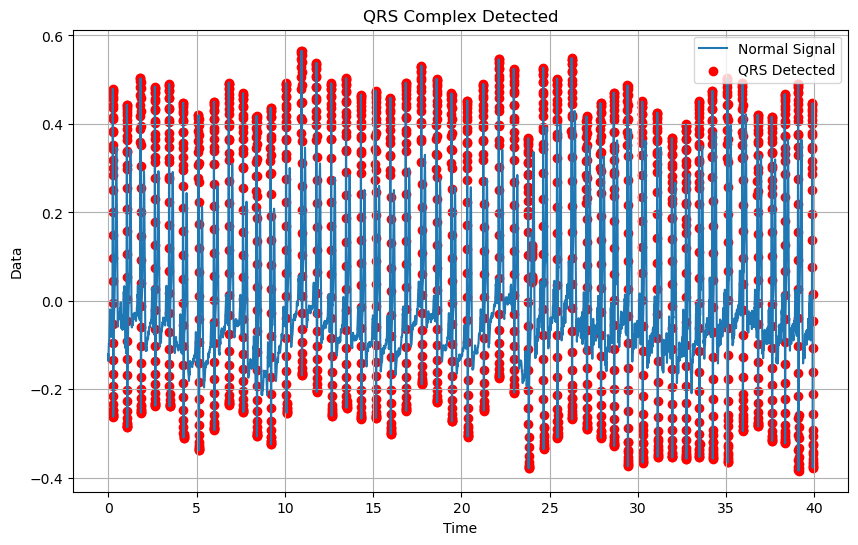

In [2303]:
# Separate features and target variable
X = df_prepared[['numerical__sec', 'numerical__CH1','numerical__Rate_of_change']]

y_pred = ml_model.predict(X)

# Find the indexes where y_pred equals 1
indexes = [i for i, pred in enumerate(y_pred) if pred == 1]

# Plot the normal signal
plt.figure(figsize=(10, 6))

test_len = np.max(indexes)
plt.plot(X["numerical__sec"][:test_len], X["numerical__CH1"][:test_len], label='Normal Signal')

# Plot markers where y_pred equals 1
plt.scatter((X["numerical__sec"])[indexes], X["numerical__CH1"][indexes], color='red', label='QRS Detected')

plt.xlabel('Time')
plt.ylabel('Data')
plt.title('QRS Complex Detected')
plt.legend()
plt.grid(True)
plt.show()

# Trying the Trained Model on other Datasets:
For this we will be using one of our datasets from lab 3

In [2304]:
# Load the dataset with comma as delimiter
df = pd.read_csv("Mahdin_Lab3-L05.txt", sep="\t")

df = df.iloc[:9000]

df['sec'] = df['sec'].apply(lambda x: float(x.split()[0])) #Mahdin's Dataset was exported with tab as adelimiter making the sec column a string, here we are converting it back to a float64

df.head()

C:\Users\joaqu\AppData\Local\Temp\ipykernel_11352\76899674.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Mahdin_Lab3-L05.txt", sep="\t")


,sec,CH1,CH40,Unnamed: 3
0,0.000,0.000000,NaN,NaN
1,0.001,0.122986,0.0,NaN
2,0.002,0.107422,0.0,NaN
3,0.003,0.091858,0.0,NaN
4,0.004,0.076904,0.0,NaN


In [2305]:
# Removing unnecessary columns
df = df.drop('Unnamed: 3', axis=1) # Unnecessary
df = df.drop('CH40', axis=1)

df.head()

,sec,CH1
0,0.000,0.000000
1,0.001,0.122986
2,0.002,0.107422
3,0.003,0.091858
4,0.004,0.076904


In [2306]:
# Get the time column
time = df.iloc[:, 0]

# Get the Channel data
data = df.iloc[:, 1]

[x_data, y_data] = rate_of_change(time, data)

# Create a DataFrame for the rate of change
rate_of_change_df = pd.DataFrame({'Rate_of_change': y_data})

# Concatenate the rate of change DataFrame with the original dataset
df = pd.concat([df, rate_of_change_df], axis=1)

In [2307]:
# Assuming numerical_columns and categorical_columns are lists of column names
numerical_columns = df.select_dtypes(include='number').columns.to_list()

# Create preprocessing pipeline for numerical columns
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))])

# Combine preprocessing pipelines for numerical columns
preprocessing_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns)],
    remainder='passthrough')

# Display the preprocessing pipeline
preprocessing_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['sec', 'CH1', 'Rate_of_change'])])

In [2308]:
# # Apply the preprocessing pipeline on the dataset
df_prepared_testing = preprocessing_pipeline.fit_transform(df)

# Scikit-learn strips the column headers in most cases, so just add them back on afterward.
feature_names=preprocessing_pipeline.get_feature_names_out()
df_prepared_testing = pd.DataFrame(data=df_prepared_testing, columns=feature_names)

df_prepared_testing

,numerical__sec,numerical__CH1,numerical__Rate_of_change
0,0.000,0.000000,18060.765136
1,0.001,0.122986,18423.102489
2,0.002,0.107422,18215.167740
3,0.003,0.091858,17450.790270
4,0.004,0.076904,16177.093753
...,...,...,...
8995,8.995,-0.095215,9463.208008
8996,8.996,-0.092468,11783.899619
8997,8.997,-0.089416,13916.417507
8998,8.998,-0.086365,15739.742976


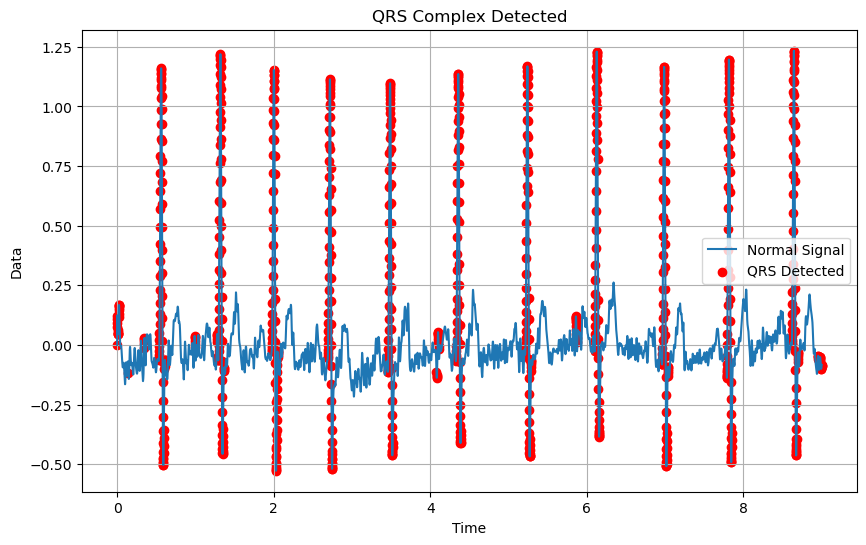

In [2309]:
# Separate features and target variable
X = df_prepared_testing[['numerical__sec', 'numerical__CH1','numerical__Rate_of_change']]

# predicting with trained model on the new dataset
y_pred = ml_model.predict(X)

# Find the indexes where y_pred equals 1
indexes = [i for i, pred in enumerate(y_pred) if pred == 1]

# Plot the normal signal
plt.figure(figsize=(10, 6))
plt.plot(X["numerical__sec"], X["numerical__CH1"], label='Normal Signal')

# Plot markers where y_pred equals 1
plt.scatter((X["numerical__sec"])[indexes], X["numerical__CH1"][indexes], color='red', label='QRS Detected')

plt.xlabel('Time')
plt.ylabel('Data')
plt.title('QRS Complex Detected')
plt.legend()
plt.grid(True)
plt.show()